# MON NAIVE BAYES

In [1]:
%pip install spacy nltk
!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
^C


In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import spacy
import string
from spacy.lang.en import English
from spacy.tokens import Doc
from spacy.tokenizer import Tokenizer
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.stem import LancasterStemmer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kvngu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kvngu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\kvngu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


True

In [2]:
df = pd.read_csv('./tweet_emotions.csv')
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [7]:
# Hapus data yg kosong
df.dropna(inplace = True)

# Hapus data duplikat
df.drop_duplicates(inplace = True)

for x in df.index:
  if df.loc[x, "sentiment"] == 'empty':
    df.drop(x,inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39173 entries, 1 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   39173 non-null  int64 
 1   sentiment  39173 non-null  object
 2   content    39173 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


In [8]:
df.head()

,tweet_id,sentiment,content
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
5,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to...


In [3]:
# Itung jumlah per sentiment
for x in df['sentiment'].unique():
    print(x, ":", df['sentiment'].value_counts()[x])

print(df['sentiment'].unique())

empty : 827
sadness : 5165
enthusiasm : 759
neutral : 8638
worry : 8459
surprise : 2187
love : 3842
fun : 1776
hate : 1323
happiness : 5209
boredom : 179
relief : 1526
anger : 110
['empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
 'hate' 'happiness' 'boredom' 'relief' 'anger']


In [4]:
# Hapus yg ratusan dan dibawah 3000 (disuruh leo)
for x in df.index:
  if (df.loc[x, "sentiment"] == 'anger' or df.loc[x, "sentiment"] == 'boredom' or df.loc[x, "sentiment"] == 'enthusiasm'
      or df.loc[x, "sentiment"] == 'fun' or df.loc[x, "sentiment"] == 'relief'
      or df.loc[x, "sentiment"] == 'surprise'
      or df.loc[x, "sentiment"] == 'worry' or df.loc[x, "sentiment"] == 'neutral'):
    df.drop(x,inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16366 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   16366 non-null  int64 
 1   sentiment  16366 non-null  object
 2   content    16366 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [5]:
mean = len(df)/len(df['sentiment'].unique())
print(mean)

3273.2


In [6]:
# Hapus baris sesuai jumlah mean
# mean = 3842
for x in df['sentiment'].unique():
    if df['sentiment'].value_counts()[x] > mean:
        dropped = int(df['sentiment'].value_counts()[x] - mean)
        df = df.drop(df[df['sentiment'] == x].tail(dropped).index)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11972 entries, 0 to 39975
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   11972 non-null  int64 
 1   sentiment  11972 non-null  object
 2   content    11972 non-null  object
dtypes: int64(1), object(2)
memory usage: 374.1+ KB


In [7]:
# Itung jumlah per sentiment
for x in df['sentiment'].unique():
    print(x, ":", df['sentiment'].value_counts()[x])

print(df['sentiment'].unique())
print(df['sentiment'].value_counts().unique())

empty : 827
sadness : 3274
love : 3274
hate : 1323
happiness : 3274
['empty' 'sadness' 'love' 'hate' 'happiness']
[3274 1323  827]


In [8]:
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
6,1956968487,sadness,"I should be sleep, but im not! thinking about ..."
8,1956969035,sadness,@charviray Charlene my love. I miss you


In [29]:
import string

# Initialize the Lancaster Stemmer from NLTK
stemmer = PorterStemmer()

# Set of valid words from NLTK's words corpus
# valid_words = set(words.words())

# Function to clean text, perform stemming, and filter words not in the corpus
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Replace non-alphanumeric characters with a single space
    text = re.sub(r'[^a-zA-Z0-9@]', ' ', text)
    
    # remove @ mention 
    # Split the text into words
    words = text.split()

    # Filter out words that start with '@'
    filtered_words = [word for word in words if not word.startswith('@')]

    # Join the filtered words back into a string
    text = ' '.join(filtered_words)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenize the text
    words = nltk.word_tokenize(text)

    # Filter words not in the corpus
    # cleaned_words = [word for word in words if word in valid_words]

    # Remove stopwords and perform stemming
    stemmed_words = [stemmer.stem(word) for word in words if word not in stopwords.words('english') and '@' not in word]
    
    cleaned_text = ' '.join(stemmed_words)
    
    return cleaned_text
# Apply the cleaning function to the 'content' column
df['cleaned_content'] = df['content'].apply(clean_text)

# Display the cleaned dataset
print(df[['content', 'cleaned_content']].head())

                                             content  \
0  @tiffanylue i know  i was listenin to bad habi...   
1  Layin n bed with a headache  ughhhh...waitin o...   
2                Funeral ceremony...gloomy friday...   
6  I should be sleep, but im not! thinking about ...   
8            @charviray Charlene my love. I miss you   

                                     cleaned_content  
0  know listenin bad habit earlier start freakin ...  
1             layin n bed headach ughhhh waitin call  
2                       funer ceremoni gloomi friday  
6  sleep im think old friend want marri damn amp ...  
8                                  charlen love miss  


Data Preparation

In [ ]:
%pip install BeautifulSoup4 scikit-learn textblob gensim
import requests
from bs4 import BeautifulSoup
import pandas as pd
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn import metrics


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\CJ\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


  Obtaining dependency information for gensim from https://files.pythonhosted.org/packages/ab/b0/d58dc405fd60ab546ca714321235dc2d455b2dc06bfb4fc1092940c749fc/gensim-4.3.2-cp310-cp310-win_amd64.whl.metadata
   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/24.0 MB 1.6 MB/s eta 0:00:15
   ---------------------------------------- 0.2/24.0 MB 2.4 MB/s eta 0:00:11
    --------------------------------------- 0.5/24.0 MB 3.5 MB/s eta 0:00:07
   - -------------------------------------- 0.9/24.0 MB 5.2 MB/s eta 0:00:05
   - -------------------------------------- 1.0/24.0 MB 5.5 MB/s eta 0:00:05
   - -------------------------------------- 1.0/24.0 MB 5.5 MB/s eta 0:00:05
   - -------------------------------------- 1.0/24.0 MB 5.5 MB/s eta 0:00:05
   - -------------------------------------- 1.0/24.0 MB 5.5 MB/s eta 0:00:05
   - -------------------------------------- 1.0/24.0 MB 5.5 MB/s eta 0:00:05
   -- -------------------------

Multinomial NB

In [ ]:
from sklearn.model_selection import train_test_split

# Load the training data from the CSV file
df_train_multinomial = df

# Preprocess the training data
x = df_train_multinomial['cleaned_content']
y = df_train_multinomial['sentiment']

# using count vectorizer
vectorizer = CountVectorizer()
x_train_vectorized = vectorizer.fit_transform(x)
# print(x_train_vectorized)
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(x_train_vectorized, y, test_size=0.12, random_state=42)

# initialize multinomialNB classifier
classifier = MultinomialNB()
classifier.fit(X_train.toarray(), y_train)

# Predict on the test data
y_pred = classifier.predict(X_test.toarray())
print(y_pred)
print(y_test)
# Evaluate the accuracy of the classifier
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


['happiness' 'happiness' 'happiness' ... 'happiness' 'love' 'happiness']
34211    happiness
27311      sadness
20969    happiness
3790     happiness
8443       sadness
           ...    
11379      sadness
5505       sadness
1637     happiness
9538       sadness
31103    happiness
Name: sentiment, Length: 1865, dtype: object
Accuracy: 0.5721179624664879


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn import metrics

# Assuming df_train_multinomial contains 'cleaned_content' and 'sentiment' columns

# Preprocessing and tokenizing the text
tokenized_text = df_train_multinomial['content'].apply(lambda x: x.split())

# Training the Word2Vec model
word2vec_model = Word2Vec(tokenized_text, vector_size=100, window=5, min_count=1, sg=0)

# Creating word embeddings
def document_embedding(text):
    embedding = []
    for word in text:
        if word in word2vec_model.wv:
            embedding.append(word2vec_model.wv[word])
    return np.mean(embedding, axis=0) if embedding else np.zeros(100)  # Return zeros if no valid words found

# Applying the Word2Vec embeddings to the text data
word_embeddings = np.vstack(tokenized_text.apply(document_embedding))
# print(word_embeddings)
# Scale the data to make it non-negative
scaler = MinMaxScaler()
word_embeddings_non_negative = scaler.fit_transform(word_embeddings)

# Target labels
y = df_train_multinomial['sentiment']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(word_embeddings_non_negative, y, test_size=0.2, random_state=42)

# Initialize SVM classifier
classifier = svm.SVC(kernel='linear')  # You can specify different kernels: 'linear', 'rbf', 'poly', etc.

# Fit the classifier to the training data
classifier.fit(X_train, y_train)

# Predict on the test data
y_pred = classifier.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.42503217503217505


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# Load the training data from the CSV file
df_train_gaussian = df

# Preprocess the training data
x = df_train_gaussian['cleaned_content']
y = df_train_gaussian['sentiment']

# using count vectorizer
vectorizer = CountVectorizer()
x_train_vectorized = vectorizer.fit_transform(x)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(x_train_vectorized, y, test_size=0.2, random_state=42)

# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Train the classifier on the training data
gnb.fit(X_train.toarray(), y_train)

# Predict on the test data
y_pred = gnb.predict(X_test.toarray())

# Evaluate the accuracy of the classifier
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.2384169884169884


COBA KNN BISMILAH

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [50]:
df_train_knn = df

x = df_train_knn['cleaned_content']
y = df_train_knn['sentiment']

# using count vectorizer
vectorizer = CountVectorizer()
x_train_vectorized = vectorizer.fit_transform(x)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(x_train_vectorized, y, test_size=0.2)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.toarray())
X_test = scaler.transform(X_test.toarray())

# Initialize the KNearest Neighbors Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

NameError: name 'accuracy_score' is not defined

In [26]:
# Make a simple request to a website that echoes back user agent information
response = requests.get('https://httpbin.org/user-agent')

# Extract and print your user agent string
user_agent = response.json()['user-agent']
print(user_agent)

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

titles = ["magics-return-i-can-see-the-spirits", "taking-the-mafia-to-the-magic-world", "ill-surpass-the-mc"]

for title in titles:
    url = f'https://www.lightnovelworld.com/novel/{title}'
    response = requests.get(url, headers=headers)
    print(response)
    data_dict = {'title': '', 'author': '', 'rating': '', 'categories': [], 'comments': [], 'sentiments': []}

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')

        # Get novel title
        title_element = soup.find('h1', class_='novel-title')
        if title_element:
            data_dict['title'] = title_element.text.strip()

        # Get author information
        author_element = soup.find('span', attrs={'itemprop': 'author'})
        if author_element:
            data_dict['author'] = author_element.text.strip()

        # Get rating information
        meta_rating_element = soup.find('meta', attrs={'itemprop': 'ratingValue'})
        if meta_rating_element:
            data_dict['rating'] = meta_rating_element.get('content', '').strip()

        # Mencari semua elemen <p> di dalam <div> dengan class 'comment-text'
        comment_text_divs = soup.find_all('div', class_='comment-text')

        for comment_text_div in comment_text_divs:
            p_elements = comment_text_div.find_all('p')

            for p_element in p_elements:
                paragraph_text = p_element.text.strip()
                data_dict['comments'].append(paragraph_text)

                # Perform sentiment analysis using TextBlob
                blob = TextBlob(paragraph_text)
                sentiment = 'positive' if blob.sentiment.polarity > 0 else 'negative' if blob.sentiment.polarity < 0 else 'neutral'
                data_dict['sentiments'].append(sentiment)

        # Get Categories
        categories_header = soup.find('h4', string='Categories')
        if categories_header:
            categories_list = []
            ul_element = categories_header.find_next('ul')
            if ul_element:
                categories = ul_element.find_all('li')
                for category in categories:
                    category_text = category.text.strip()
                    categories_list.append(category_text)
                data_dict['categories'] = categories_list

        # Print each comment with its predicted sentiment
        print(data_dict)
        for comment, sentiment in zip(data_dict['comments'], data_dict['sentiments']):
            print(f"Comment: {comment}")
            print(f"Predicted Sentiment: {sentiment}\n")
    else:
        print(f"Gagal mengambil halaman web untuk judul {title}. Kode status:", response.status_code)


NameError: name 'requests' is not defined

Desicion Tree

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

# Membaca data dari CSV
data = pd.read_csv('tweet_emotions.csv')

# Mengubah teks menjadi fitur numerik dengan CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['content'])

# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, data['sentiment'], test_size=0.2, random_state=42)

# Membuat dan melatih model Decision Tree
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Menguji model
print("Accuracy : ",model.score(X_test, y_test))

Accuracy :  0.264375


Accuracy :  0.45386221294363255


[Text(0.9756204671429205, 0.9986842105263158, 'x[5984] <= 0.5\ngini = 0.759\nsamples = 2395\nvalue = [162, 623, 271, 654, 685]'),
 Text(0.9573357794109244, 0.9960526315789474, 'x[6650] <= 0.5\ngini = 0.761\nsamples = 2157\nvalue = [159, 594, 269, 476, 659]'),
 Text(0.9450006690871443, 0.993421052631579, 'x[4396] <= 0.5\ngini = 0.76\nsamples = 2101\nvalue = [158, 589, 267, 428, 659]'),
 Text(0.9325201386897508, 0.9907894736842106, 'x[8636] <= 0.5\ngini = 0.755\nsamples = 2040\nvalue = [157, 589, 225, 425, 644]'),
 Text(0.9185878452641622, 0.9881578947368421, 'x[10036] <= 0.5\ngini = 0.758\nsamples = 1982\nvalue = [157, 586, 223, 422, 594]'),
 Text(0.9040738715441199, 0.9855263157894737, 'x[6506] <= 0.5\ngini = 0.758\nsamples = 1888\nvalue = [151, 538, 219, 388, 592]'),
 Text(0.887235614354202, 0.9828947368421053, 'x[4361] <= 0.5\ngini = 0.761\nsamples = 1799\nvalue = [148, 529, 216, 371, 535]'),
 Text(0.8715534046293739, 0.9802631578947368, 'x[4038] <= 0.5\ngini = 0.763\nsamples = 1734\

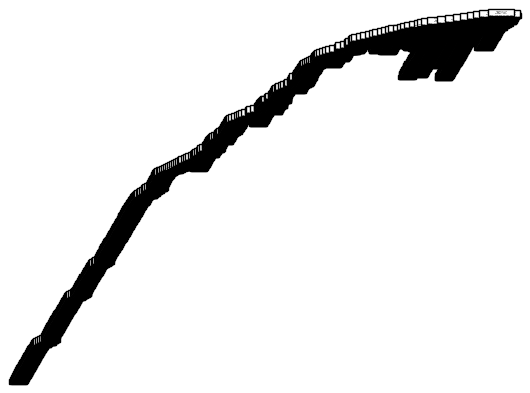

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn import tree

# Membaca data dari CSV
df_train_tree = df

x = df_train_tree['cleaned_content']
y = df_train_tree['sentiment']
data_dict = {'title': '', 'author': '', 'rating': '', 'categories': [], 'comments': [], 'sentiments': []}

features = ['title', 'author', 'rating', 'categories', 'comments', 'sentiments']


# Mengubah teks menjadi fitur numerik dengan CountVectorizer
vectorizer = CountVectorizer()
X_count_vectorized = vectorizer.fit_transform(x)

# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_tradf
in, y_test = train_test_split(X_count_vectorized, y, test_size=0.2, random_state=42)

# Membuat dan melatih model Decision Tree
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Menguji model
print("Accuracy : ",model.score(X_test, y_test))
dtree = model.fit(X_test, y_test)
tree.plot_tree(dtree)

Support Vector Machine

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
import matplotlib.pyplot as plt
import pandas as pd

df_train_tree = df

x = df_train_tree['cleaned_content']
y = df_train_tree['sentiment']
data_dict = {'title': '', 'author': '', 'rating': '', 'categories': [], 'comments': [], 'sentiments': []}

# Mengubah teks menjadi fitur numerik dengan CountVectorizer
vectorizer = CountVectorizer()
X_count_vectorized = vectorizer.fit_transform(x)

# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X_count_vectorized, y, test_size=0.2, random_state=42)

# Membuat dan melatih model SVM
model = svm.SVC(kernel='linear')
model.fit(X_train, y_train)

# Menguji model
print("Accuracy : ",model.score(X_test, y_test))



Accuracy :  0.5022964509394572
